[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eohta/md-nrm-numpyro-kobe/blob/main/10.001-numpyro_md_nrm_vec.ipynb)

# original MDNRM

In [1]:
! pip install -q numpyro==0.10.1 watermark==2.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.7/292.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
import jax
import numpyro
import numpyro.distributions as dist

import arviz as az

In [4]:
numpyro.set_platform('cpu')
numpyro.set_host_device_count(8)

## Import & Check Data

In [5]:
! wget https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/nrm_ground_truth_and_results.csv -O ground_truth_and_results.csv

--2024-04-05 21:40:51--  https://filedn.com/lpAczQGgeBjkX6l7SpI5JJy/__ws/stan_irt_nrm_rad/nrm_ground_truth_and_results.csv
Resolving filedn.com (filedn.com)... 74.120.9.25
Connecting to filedn.com (filedn.com)|74.120.9.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2272 (2.2K) [text/csv]
Saving to: ‘ground_truth_and_results.csv’

ground_truth_and_re 100%[===================>]   2.22K  --.-KB/s    in 0s      

2024-04-05 21:40:51 (789 MB/s) - ‘ground_truth_and_results.csv’ saved [2272/2272]



In [6]:
df = pd.read_csv('./ground_truth_and_results.csv')

In [7]:
df.head()

,GT,MN,YU,EN,HM,DK,YW
0,1,1,0,1,1,1,1
1,1,1,1,1,1,1,0
2,0,1,0,0,0,0,0
3,1,1,1,2,2,2,2
4,1,1,1,1,1,2,2


In [8]:
df = df + 1


In [9]:
df.head()

,GT,MN,YU,EN,HM,DK,YW
0,2,2,1,2,2,2,2
1,2,2,2,2,2,2,1
2,1,2,1,1,1,1,1
3,2,2,2,3,3,3,3
4,2,2,2,2,2,3,3


In [10]:
df.describe()

,GT,MN,YU,EN,HM,DK,YW
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,2.000000,1.993333,2.026667,2.000000,1.766667,1.973333,1.606667
std,0.819232,0.823291,0.818795,0.819232,0.870213,0.826951,0.818385
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000
75%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [11]:
print( 0, (df["GT"]==0).sum() )
print( 1, (df["GT"]==1).sum() )
print( 2, (df["GT"]==2).sum() )
print( 3, (df["GT"]==2).sum() )

# 1 -> normal
# 2 -> non-COVID19 pneumonia
# 3 -> COVID19 pneumonia

0 0
1 50
2 50
3 50


## Convert Data

In [12]:
num_classes = 3

In [13]:
rad_resp = df.iloc[:,1:].copy()


In [14]:
num_cases = rad_resp.shape[0]
num_doctors = rad_resp.shape[1]
gt_types = df["GT"]


In [15]:
print(num_cases)
print(num_doctors)

150
6


In [16]:
gt_types

0      2
1      2
2      1
3      2
4      2
      ..
145    2
146    2
147    3
148    3
149    3
Name: GT, Length: 150, dtype: int64

In [17]:
rad_resp

,MN,YU,EN,HM,DK,YW
0,2,1,2,2,2,2
1,2,2,2,2,2,1
2,2,1,1,1,1,1
3,2,2,3,3,3,3
4,2,2,2,2,3,3
...,...,...,...,...,...,...
145,2,2,2,3,3,3
146,2,2,2,2,2,2
147,3,3,2,3,3,3
148,3,3,3,1,2,3


In [18]:
num_classes = 3

In [19]:
y = rad_resp.to_numpy() - 1
y_true = gt_types.to_numpy() - 1

In [20]:
print(y.shape)
print(y_true.shape)

(150, 6)
(150,)


## Generate Index



In [21]:
i_beta = np.zeros((num_cases, num_doctors), dtype=int)

for i in range(num_cases):
    for j in range(num_doctors):
        i_beta[i, j] = i


In [22]:
print(i_beta.shape)

(150, 6)


## Define Model

### Overview of Paramters

**theta** : radiologist's ability
- theta.shape: (number of classes) x (number of radiologists) x (number of classes)

**beta** : item's difficulty
- beta.shape: (number of items) x (number of classes)


In [23]:
theta_sd = 2
beta_sd = 2

In [24]:
def model(y=None, y_true=None, i_beta=None, num_cases=0, num_doctors=0, num_classes=0):

    theta = numpyro.sample('theta', dist.Normal(0, theta_sd), sample_shape=(num_classes, num_doctors, num_classes))
    beta = numpyro.sample('beta', dist.Normal(0, beta_sd), sample_shape=(num_cases, num_classes))

    # logits.shape : (num_cases, num_doctors, num_classes)
    logits = theta[y_true, :, :] + beta[i_beta, :]

    numpyro.sample('obs', dist.Categorical(logits=logits), obs=y)

## Inference

In [25]:
nuts = numpyro.infer.NUTS(model)

In [26]:
%%time

mcmc = numpyro.infer.MCMC(nuts, num_warmup=1000, num_samples=8000, num_chains=8)

mcmc.run(jax.random.PRNGKey(0), y=y, y_true=y_true, i_beta=i_beta, num_cases=num_cases, num_doctors=num_doctors, num_classes=num_classes)
mcmc_samples = mcmc.get_samples()

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

  0%|          | 0/9000 [00:00<?, ?it/s]

CPU times: user 4min 16s, sys: 1.08 s, total: 4min 17s
Wall time: 2min 44s


## Evaluate Results

In [27]:
idata = az.from_numpyro(mcmc)
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


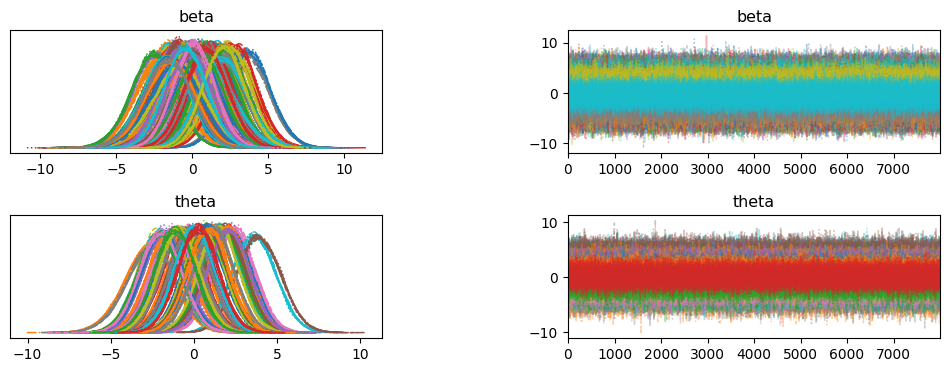

In [28]:
axes = az.plot_trace(idata)
plt.gcf().subplots_adjust(wspace=0.5, hspace=0.5)

In [29]:
az.summary(idata, var_names=['theta'])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"theta[0, 0, 0]",2.286,1.215,0.018,4.594,0.005,0.004,49289.0,48260.0,1.0
"theta[0, 0, 1]",-0.392,1.240,-2.754,1.918,0.006,0.004,50017.0,47973.0,1.0
"theta[0, 0, 2]",-1.890,1.285,-4.307,0.519,0.006,0.004,50850.0,51066.0,1.0
"theta[0, 1, 0]",2.033,1.212,-0.255,4.304,0.006,0.004,47055.0,47519.0,1.0
"theta[0, 1, 1]",-1.027,1.241,-3.385,1.275,0.006,0.004,47719.0,49044.0,1.0
"theta[0, 1, 2]",-1.010,1.247,-3.366,1.307,0.006,0.004,47522.0,48846.0,1.0
"theta[0, 2, 0]",2.442,1.222,0.106,4.682,0.005,0.004,50311.0,47299.0,1.0
"theta[0, 2, 1]",-1.037,1.257,-3.424,1.299,0.006,0.004,51775.0,50633.0,1.0
"theta[0, 2, 2]",-1.389,1.273,-3.793,0.989,0.006,0.004,51614.0,49564.0,1.0
"theta[0, 3, 0]",3.640,1.287,1.227,6.059,0.005,0.004,57496.0,51383.0,1.0


## Evaluate Rhat

Evaluate whether the Rhat values of all parameters are less than 1.10.

In [30]:
df = az.summary(idata)

In [31]:
df['r_hat']

beta[0, 0]        1.0
beta[0, 1]        1.0
beta[0, 2]        1.0
beta[1, 0]        1.0
beta[1, 1]        1.0
                 ... 
theta[2, 4, 1]    1.0
theta[2, 4, 2]    1.0
theta[2, 5, 0]    1.0
theta[2, 5, 1]    1.0
theta[2, 5, 2]    1.0
Name: r_hat, Length: 504, dtype: float64

In [32]:
np.count_nonzero(df['r_hat'] > 1.1)

0

## Evaluate Theta

In [33]:
# Doctor's ids to compare
idA = 1
idB = 5

In [34]:
theta = idata.posterior['theta'].to_numpy()
theta = theta.swapaxes(2, 3)
theta.shape

(8, 8000, 6, 3, 3)

In [35]:
theta_idA = theta[:, :, idA, 2, 2]
theta_idB = theta[:, :, idB, 2, 2]

print(theta_idA.shape)
print(theta_idB.shape)

(8, 8000)
(8, 8000)


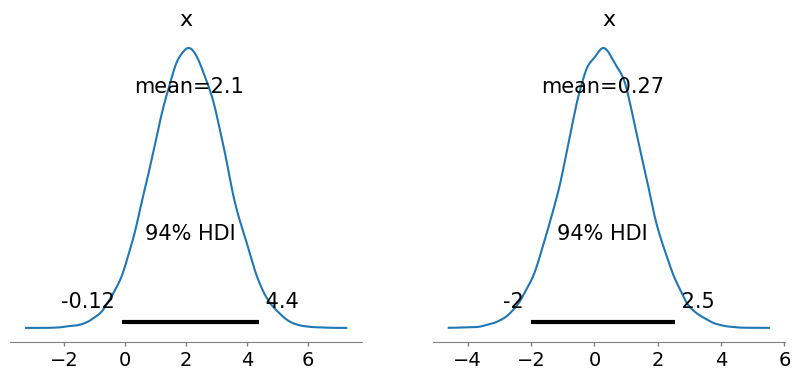

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

az.plot_posterior(theta_idA, ax=axes[0])
az.plot_posterior(theta_idB, ax=axes[1])

plt.show()

In [37]:
d = theta_idA - theta_idB

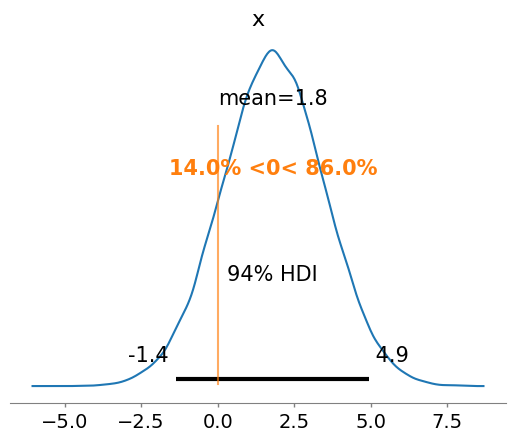

In [38]:
az.plot_posterior(d, ref_val=0)
plt.show()

## Calculate WAIC and LOO

In [39]:
az.waic(idata, scale='deviance')

<ipython-input-39-aa33c236106c>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(idata, scale='deviance')
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 64000 posterior samples and 900 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  1147.21    47.82
p_waic          187.07        -

There has been a warning during the calculation. Please check the results.

In [40]:
az.loo(idata, scale='deviance')

<ipython-input-40-f6188337fe90>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.loo(idata, scale='deviance')
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 64000 posterior samples and 900 observations log-likelihood matrix.

             Estimate       SE
deviance_loo  1176.90    49.58
p_loo          201.91        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      839   93.2%
 (0.5, 0.7]   (ok)         56    6.2%
   (0.7, 1]   (bad)         5    0.6%
   (1, Inf)   (very bad)    0    0.0%

## Environment

In [41]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Apr 05 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpyro   : 0.10.1
jax       : 0.4.23
arviz     : 0.15.1
numpy     : 1.25.2
pandas    : 2.0.3
matplotlib: 3.7.1

Watermark: 2.3.1

